In [45]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [46]:
import numpy as np
import pandas as pd

In [47]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")
conn = engine.connect()

# reflect an existing database into a new model

In [50]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [51]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [55]:
# Taking a look at the first row of the station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f85ca569dd0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [56]:
# Taking a look at the first row of the station table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f85ca570310>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

# Exploratory Climate Analysis

In [57]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date)[-1]
last_date

('2017-08-23')

In [58]:
last_twlv = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()
last_twlv

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [59]:
# Get values from last twelve month results into seperate lists for dataframe.
dates = []
precipitation = []

for i in last_twlv:
    dates.append(i[0])
    precipitation.append(i[1])

In [60]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({'Date': dates, 'Precipitation': precipitation}).set_index('Date')

In [61]:
# Sort the dataframe by date
df.sort_values('Date', inplace=True)

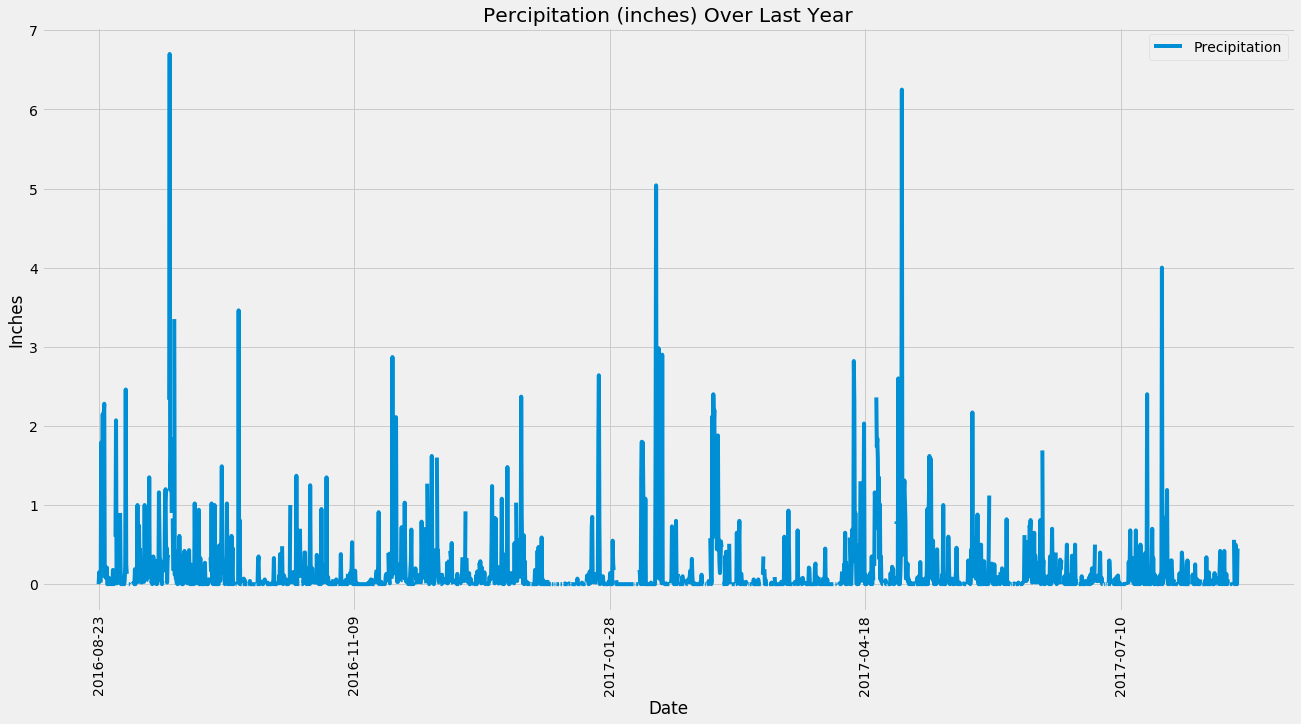

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize =(20,10), rot=90)
plt.title('Percipitation (inches) Over Last Year')
plt.ylabel('Inches')
plt.savefig('images/precipitation.png', bbox_inches = 'tight', dpi=150)
plt.show()

In [63]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()  

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [64]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).count()
stations

19550

In [65]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

count_ = func.count('*')

results = session.query(Measurement.station, count_).\
        filter(Measurement.station != '').\
        group_by(Measurement.station).\
        order_by(count_.desc()).all()
station = []
station_count = []

for r in results:
    station.append(r[0])
    station_count.append(r[1])

station_df = pd.DataFrame({'Station ID': station, 'Station Count': station_count}).set_index('Station ID')    
station_df


,Station Count
Station ID,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [66]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The lowest temp is {min_temp}")

The lowest temp is (54.0,)


In [67]:
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The highest temp is {max_temp}")

The highest temp is (85.0,)


In [68]:
avgr_temp = session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.station == 'USC00519281').first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The average temp is {avg_temp} or {avgr_temp} rounded.")

The average temp is (71.66378066378067,) or (72.0,) rounded.


In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [70]:
# Query to find the station with highest number of temp observations
highest_observ = session.query(Measurement.station, Measurement.tobs, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
highest_observ

('USC00519281', 70.0, 2772)

In [71]:
# last twelve temp observations 
last_twlv_observ = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()
last_twlv_observ

[('USC00519281', '2016-08-23', 77.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC005192

In [72]:
dates = []
temps = []

for i in last_twlv_observ:
    dates.append(i[1])
    temps.append(i[2])

In [73]:
temp_df = pd.DataFrame({'Date': dates, 'Temp': temps}).set_index('Date')

In [74]:
temp_df.sort_values('Date', inplace=True)

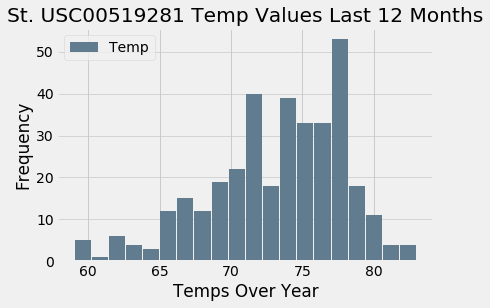

In [75]:
size, scale = 1000, 10

temp_df.plot.hist(grid=True, bins=20, rwidth=.94,
                   color='#607c8e')
plt.title('St. USC00519281 Temp Values Last 12 Months')
plt.xlabel('Temps Over Year')
plt.ylabel('Frequency')
plt.savefig('images/station-histogram.png', bbox_inches = 'tight', dpi=150)
plt.grid(axis='y', alpha=0.75)

## Bonus Challenge Assignment

In [76]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
       

    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [77]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-02-10'
end_date = '2017-02-20'
temp_stats = calc_temps(start_date,end_date)[0]
temp_stats

(62.0, 71.40298507462687, 80.0)

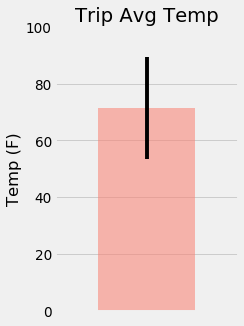

In [83]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = [0]
y_pos = [temp_stats[1]]
error = [(temp_stats[2] - temp_stats[0])]

plt.figure(figsize=(3, 5), dpi=70)
plt.bar(x_pos,y_pos,color='salmon', yerr=error, alpha=.55)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.savefig('images/temperature.png', bbox_inches = 'tight', dpi=150)
plt.show()

In [79]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-02-10'
end_date = '2017-02-20'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
rain_st = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
per_station = pd.DataFrame(rain_st, columns=['Station','Name','Latitude','Longitude','Elevation','Total_Rain'])
per_station


,Station,Name,Latitude,Longitude,Elevation,Total_Rain
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,5.85
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,5.77
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.68
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,4.98
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,3.01
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.87
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [80]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [81]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [82]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
